In [2]:
from functools import reduce
from pathlib import Path
from collections import Counter
from dataclasses import dataclass

from fastai.basic_train import get_preds, LearnerCallback, Learner
from fastai.text import *
from fastai.datasets import *
from fastai.metrics import *
from fastai.train import *
from fastai.vision import *
from fastai.callback import Callback
from fastai.callbacks import SaveModelCallback
import pandas as pd

from fastai.imports import nn, torch
from sklearn import metrics
import sklearn.metrics
import altair as alt

import news_utils

%load_ext autoreload
%autoreload 2

alt.renderers.enable('notebook')
torch.cuda.set_device(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
EX_PA = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/persuasive_maj/')
MODELS = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/lm_models/')
LM_DATA_PATH = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/lm_data/')

tokenizer = Tokenizer(special_cases = ['xxbos','xxfld','xxunk','xxpad', 'xxsep'])
# tokenizer = None

data_lm_train = pd.read_csv(LM_DATA_PATH/'train.csv')
data_lm_val = pd.read_csv(LM_DATA_PATH/'val.csv')

# Language model data
data_lm = TextLMDataBunch.from_df(LM_DATA_PATH, data_lm_train, data_lm_val, tokenizer=tokenizer)

In [4]:
data_clas_train = pd.read_csv(EX_PA/'train.csv')
data_clas_val = pd.read_csv(EX_PA/'val.csv')

data_clas = news_utils.RandomSampler.TextClasDataBunchRandom.from_df(EX_PA, data_clas_train, data_clas_val, vocab=data_lm.train_ds.vocab, bs=50, txt_cols=['text'], label_cols=['class'], num_samples=2000)

In [26]:
learn = language_model_learner(data_lm, pretrained_fnames=['lstm_wt103', 'itos_wt103'], drop_mult=0.5)

In [27]:
learn.fit_one_cycle(1, 1e-2)

Total time: 05:28
epoch  train_loss  valid_loss  accuracy
1      4.702953    4.542753    0.238456  (05:28)



In [28]:
# learn.load_encoder(MODELS/'ft_enc_05_30')
learn.unfreeze()
learn.fit_one_cycle(, 1e-3)

Total time: 06:23
epoch  train_loss  valid_loss  accuracy
1      4.388505    4.368560    0.254820  (06:23)



In [29]:
learn.save_encoder(MODELS/'06_11-_18')

In [3]:
# weights = [1,1, 1, 1]
# class_weights = torch.FloatTensor(weights).cuda()
# loss_func = nn.CrossEntropyLoss(weight=class_weights)

In [8]:
learn2 = text_classifier_learner(data_clas, drop_mult=1)
learn2.load_encoder(MODELS/'ft_enc_05_30_continued')

# F1 score and save only best f1 macro score
@dataclass
class F1Macro(Callback):
    name:str='F1_macro'
    
    def on_epoch_begin(self, **kwargs):
        self.y_pred, self.y_true = [], []
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        _, idxs = torch.max(last_output, 1)
        self.y_pred += idxs.tolist()
        self.y_true += last_target.tolist()
    
    
    def on_epoch_end(self, **kwargs):
        f1_macro = sklearn.metrics.f1_score(self.y_pred, self.y_true, average='macro')
        self.metric = f1_macro

        
learn2.metrics = [F1Macro()]

learn2.callbacks += [SaveModelCallback(learn2, 'F1_macro', 'max', name='getreal1k_pers')]

learn2.fit(100, 1e-4)

Total time: 08:42
epoch  train_loss  valid_loss  F1_macro
1      0.729313    0.569336    0.567760  (00:05)
2      0.725022    0.578666    0.583962  (00:07)
3      0.718561    0.613760    0.531918  (00:04)
4      0.709543    0.635187    0.530356  (00:04)
5      0.705374    0.627971    0.533254  (00:04)
6      0.701671    0.628831    0.541713  (00:04)
7      0.698915    0.628613    0.548470  (00:05)
8      0.699037    0.546233    0.603774  (00:04)
9      0.701818    0.570575    0.600201  (00:05)
10     0.704015    0.544448    0.568900  (00:04)
11     0.701765    0.580926    0.575541  (00:05)
12     0.691833    0.609509    0.538864  (00:05)
13     0.695448    0.669078    0.483378  (00:05)
14     0.693949    0.687696    0.454668  (00:05)
15     0.691964    0.654025    0.509028  (00:04)
16     0.682793    0.636547    0.531834  (00:05)
17     0.685570    0.572104    0.570755  (00:05)
18     0.682504    0.596265    0.593889  (00:04)
19     0.683786    0.609235    0.561813  (00:06)
20     0.68

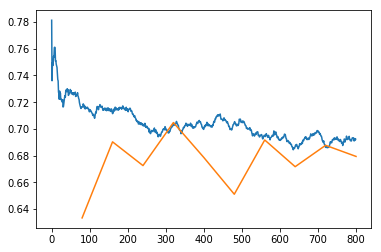

In [12]:
learn2.recorder.plot_losses()

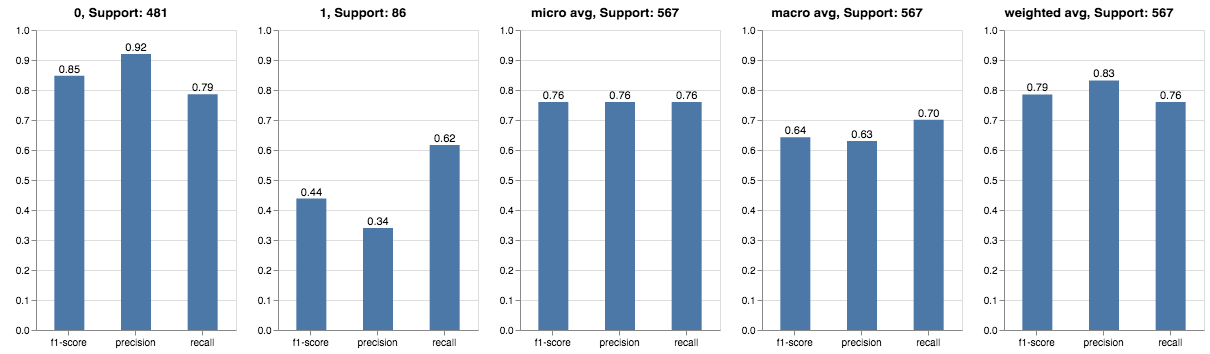

SankeyWidget(links=[{'source': 'true not pers', 'target': 'pred not pers', 'type': 'cor', 'value': 378}, {'sou…

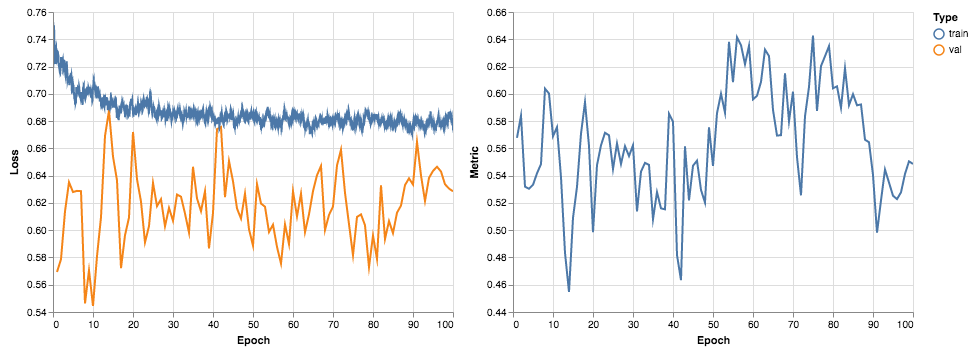

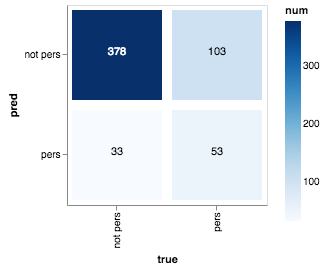

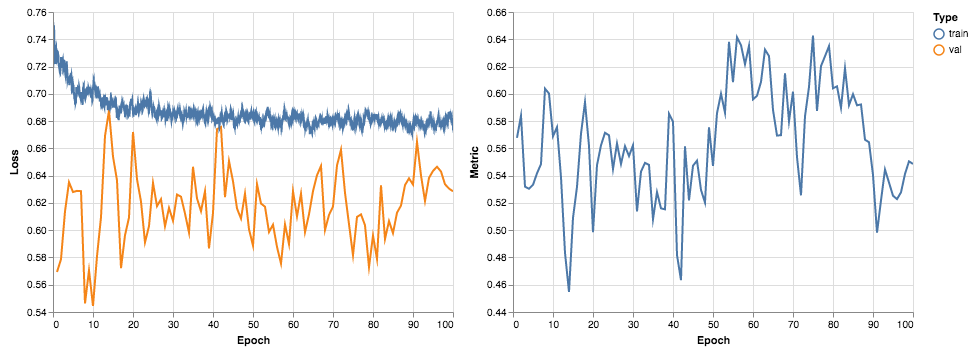

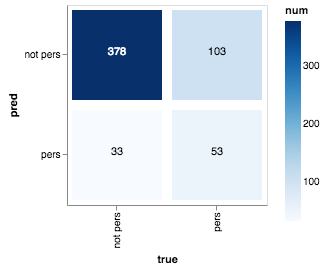

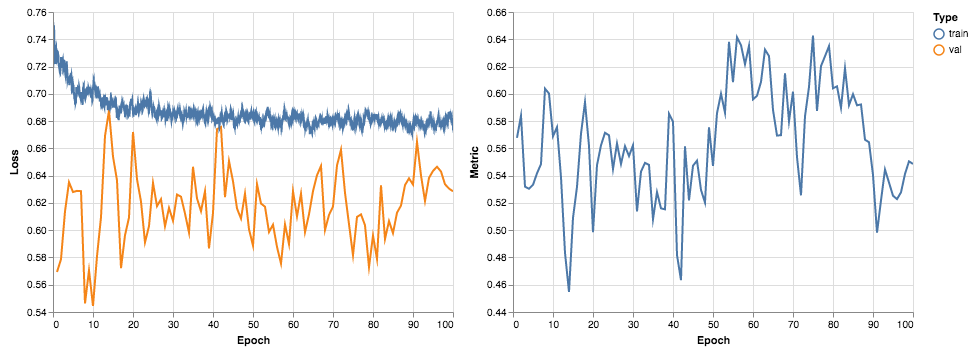

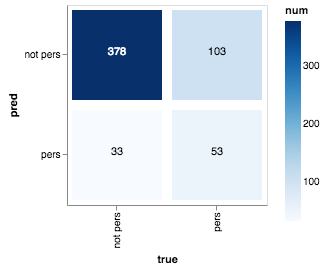

In [9]:
news_utils.plot.all(learn2, labels=['not pers','pers'])

In [62]:
learn3 = text_classifier_learner(data_clas, drop_mult=1)
learn3.load('getreal1k')
learn3.metrics = [F1Macro()]
learn3.callbacks += [SaveModelCallback(learn3, 'F1_macro', 'max', name='getreal1k_2_2')]

In [63]:
learn3.freeze_to(-2)
learn3.fit(100, slice(1e-5/2, 1e-5))

Total time: 07:14
epoch  train_loss  valid_loss  F1_macro
1      1.243046    1.144025    0.429561  (00:03)
2      1.234400    1.155096    0.437786  (00:04)
3      1.255607    1.166967    0.440783  (00:04)
4      1.225963    1.161678    0.411633  (00:04)
5      1.220841    1.153277    0.423021  (00:04)
6      1.237482    1.134307    0.433512  (00:03)
7      1.238692    1.150320    0.447011  (00:04)
8      1.243704    1.160760    0.453158  (00:04)
9      1.259443    1.153121    0.444342  (00:04)
10     1.264287    1.138414    0.439587  (00:04)
11     1.259172    1.144726    0.437875  (00:04)
12     1.239663    1.141790    0.434214  (00:04)
13     1.254754    1.162386    0.432667  (00:04)
14     1.242015    1.133329    0.440151  (00:04)
15     1.248278    1.145913    0.435239  (00:04)
16     1.249342    1.170175    0.427763  (00:04)
17     1.248066    1.156698    0.435325  (00:04)
18     1.245178    1.162850    0.426810  (00:04)
19     1.232711    1.122910    0.442809  (00:04)
20     1.25